In [1]:

import os 
import pickle 
import evaluate_predictions
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import pstats
import re

datapath = "../data/efficiency_test/"

### Overview --  to be finished




#### Compare ED predictions with/without coref, across data sets 

In [2]:
# load single data set 
path_predictions = f"{datapath}predictions/"
files = os.listdir(path_predictions)
predictions = {}

for f in files:
    with open(f"{path_predictions}{f}", "rb") as file:
        f = re.sub(".pickle", "", f)
        predictions[f] = pickle.load(file)

In [3]:
for version, d in predictions.items():
    # this only works for the aida test data sets 
    if "aida_test" in version:
        print(f"Evaluating predictions for {version}")
        evaluate_predictions.evaluate(d["predictions"])

Evaluating predictions for aida_testB_50_nocoref
Results: PMD RMD FMD PEL REL FEL: 97.4% 61.9% 75.7% | 65.7% 41.7% 51.0%
Evaluating predictions for aida_testB_500
Results: PMD RMD FMD PEL REL FEL: 97.9% 62.9% 76.6% | 62.1% 39.9% 48.6%
Evaluating predictions for aida_testB_500_nocoref
Results: PMD RMD FMD PEL REL FEL: 97.9% 62.9% 76.6% | 62.1% 39.9% 48.6%
Evaluating predictions for aida_testB_50
Results: PMD RMD FMD PEL REL FEL: 97.4% 61.8% 75.7% | 65.8% 41.7% 51.1%


#### Profile ED with/without coref, across data sets

In [4]:
path_profiling = f"{datapath}profile/"
files = os.listdir(path_profiling)
predictions = {}

for file in files:
    f = f"{path_profiling}{file}"
    d = pd.read_csv(f)
    file = re.sub(".csv", "", file)
    predictions[file] = d


In [5]:
d_list = []
# keep_strings = 'code object predict|code object with_coref'
keep_strings = 'predict|with_coref'

for filename, d in predictions.items():
    data = d.loc[d['fn'].str.contains(keep_strings), :].copy()
    data = data.loc[data['fn'] != 'predict', :]
    data['src'] = filename
    # data['func'] = np.where(data['fn'].str.contains('with_coref'), 'with_coref', 'predict')
    d_list.append(data)

df = pd.concat(d_list)



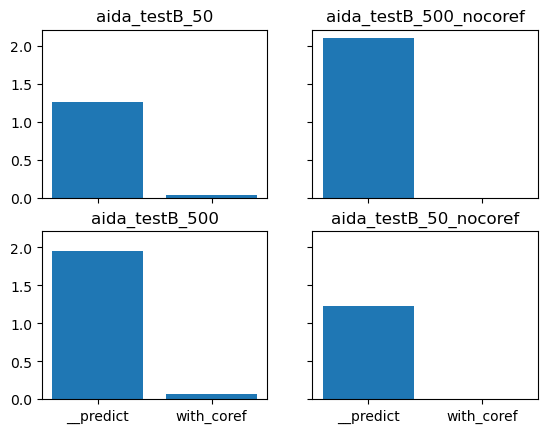

In [6]:
groups = df['src'].unique()
idxs = [[x, y] for x in range(2) for y in range(2)]

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

i = 0
for g in groups:
    dtemp = df.loc[df.src == g]
    col_idx = idxs[i][0]
    row_idx = idxs[i][1]
    x = dtemp['fn']
    y = dtemp['cumtime']
    axs[row_idx, col_idx].bar(x=x, height=y)
    axs[row_idx, col_idx].set_title(g)
    i += 1




- if this is so large, then still make the plot for the simulated large data!

#### Time complexity of entity disambiguation

In [7]:
time_dataset = {}
inputs = {
    "coref_yes": "",
    "coref_no": "_nocoref"
}
path_mentions_time = f"{datapath}n_mentions_time/"
for k, suffix in inputs.items():
    with open(f"{path_mentions_time}aida_testB{suffix}.pickle", "rb") as file:
        data = pickle.load(file)
        time_dataset[k] = data



In [8]:
time_dataset["coref_no"]["1163testb"].keys()
# time_dataset["coref_no"]["1163testb"]["profile"].head()

dict_keys(['n_mentions', 'time', 'profile'])

In [9]:

timing_overall = {}
for condition, conditiondata in time_dataset.items():
    d = []
    for docid, data in conditiondata.items():
        temp2 = {docid: {measure: value for measure, value in data.items() if measure in ["n_mentions", "time"]}}
        temp2 = pd.DataFrame.from_dict(temp2, orient="index")
        d.append(temp2)
    timing_overall[condition] = pd.concat(d)



Text(0, 0.5, 'time (seconds)')

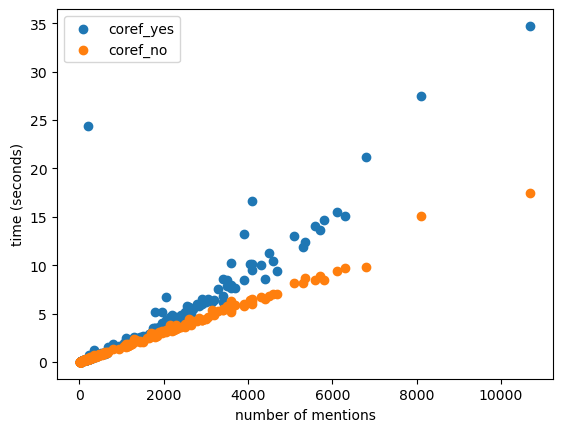

In [10]:
fig, ax = plt.subplots()

xs = [d['n_mentions'] for d in timing_overall.values()]
ys = [d['time'] for d in timing_overall.values()]

# x = [v["n_mentions", "time"] for v in time_dataset.values()]

for lbl, d in timing_overall.items():
    x = d['n_mentions']
    y = d['time']
    ax.scatter(x=x, y=y, label=lbl)

ax.legend()
ax.set_xlabel("number of mentions")
ax.set_ylabel("time (seconds)")


In [11]:
def filter_df(df, keep_strings, src):
    df = df.loc[df["fn"].str.contains(keep_strings), :].copy()
    df = df.loc[df['fn'] != "predict"] # predict calls with_coref, get_data_items, __predict
    df['src'] = src
    return df 

timing_profile = []
for condition, conditiondata in time_dataset.items():
    print(condition)
    d = []
    for docid, data in conditiondata.items():
        d_profile = filter_df(data["profile"], keep_strings=keep_strings, src=filename)
        d_profile['n_mentions'] = data['n_mentions']



        # temp2 = {docid: {measure: value for measure, value in data.items() if measure in ["n_mentions", "profile"]}}
        # temp2[docid]['profile'] = filter_df(temp2[docid]['profile'], keep_strings=keep_strings, src=filename)
        # temp2 = pd.DataFrame.from_dict(temp2, orient="index")
        d.append(d_profile)
    df_out = pd.concat(d)
    df_out['condition'] = condition
    timing_profile.append(df_out)
    
# do the same for the profiling output, process as above 
timing_profile = pd.concat(timing_profile)


coref_yes
coref_no


In [12]:
timing_profile.head()

,file,line,fn,cc,ncalls,tottime,cumtime,callers,src,n_mentions,condition
118,/home/flavio/projects/rel20/REL/src/REL/entity...,521,__predict,1,1,0.000380,0.018163,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,39,coref_yes
168,/home/flavio/projects/rel20/REL/src/REL/traini...,108,with_coref,1,1,0.000019,0.000451,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,39,coref_yes
119,/home/flavio/projects/rel20/REL/src/REL/entity...,521,__predict,1,1,0.047441,0.498564,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,195,coref_yes
168,/home/flavio/projects/rel20/REL/src/REL/traini...,108,with_coref,1,1,0.000125,0.017074,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,195,coref_yes
119,/home/flavio/projects/rel20/REL/src/REL/entity...,521,__predict,1,1,0.109560,0.649034,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,390,coref_yes


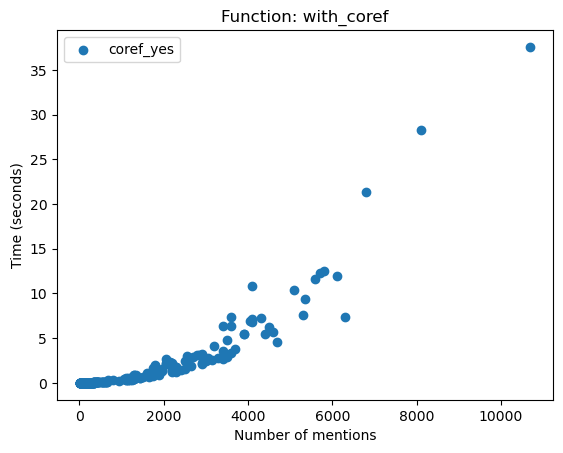

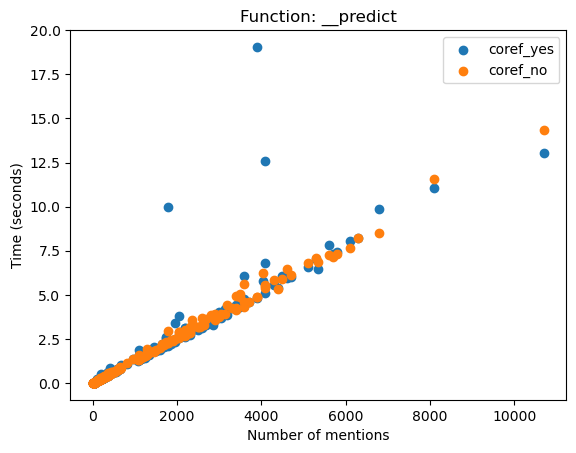

In [13]:

xlabel = 'Number of mentions'
ylabel = 'Time (seconds)'

for fnc in ['with_coref', '__predict']:
    fig, ax = plt.subplots()

    dtemp = timing_profile.loc[timing_profile['fn'] == fnc, :] # plot the timing for the function predict 
    conditions = dtemp['condition'].unique()

    for c in conditions:
        d = dtemp.loc[dtemp['condition'] == c, :]
        ax.scatter(x=d['n_mentions'], y=d['cumtime'], label=c)
        


    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"Function: {fnc}")




Text(0.5, 1.0, 'Comparing function timing when coref is on')

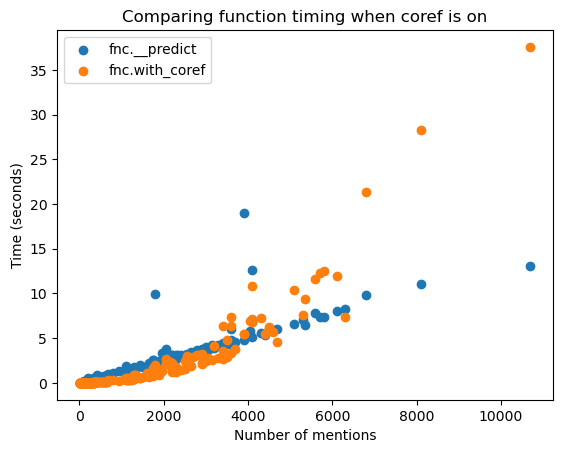

In [14]:
fig, ax = plt.subplots()
dtemp = timing_profile.loc[timing_profile['condition'] == "coref_yes", :]
functions = ['__predict', 'with_coref']

for fn in functions:
    fn_label = f"fnc.{fn}"
    d = dtemp.loc[dtemp['fn'] == fn, :]
    ax.scatter(x=d['n_mentions'], y=d['cumtime'], label=fn_label)


ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title("Comparing function timing when coref is on")

## What is going on?
- with_coref grows quadratically, that is expected 
- time for __predict does not depend on whether we use with_coref or not 
- the overhead of predict is quite large, only at around 4000 mentions the with_coref effects dominates 

## Compare predictions on data sets with many mentions

In [15]:
msmarcopath = "../data/msmarco/predictions/"

In [16]:
ed_coref = pd.read_parquet(f"{msmarcopath}ed_coref.parquet")
ed_nocoref = pd.read_parquet(f"{msmarcopath}ed_nocoref.parquet")

for d in [ed_coref, ed_nocoref]:
    d.drop(columns="md_score", inplace=True)

In [17]:
d = {"coref": ed_coref, "nocoref": ed_nocoref}
colnames_to_change = ["entity", "ed_score", "tag"]

for key, df in d.items():
    cols = df.columns 
    new_colnames = [f"{x}_{key}" if x in colnames_to_change else x for x in cols]
    d[key].columns = new_colnames


ed_nocoref = ed_nocoref.drop(columns='is_coref')

# colnames_ed = ed_coref.columns
# colnames_ed = [f"{x}_coref" if x in colnames_to_change else x for x in colnames_ed ]
# ed_coref.columns = colnames_ed

In [18]:
display(ed_coref.head())
ed_nocoref.head()

,doc_id,field,start_pos,end_pos,entity_coref,ed_score_coref,tag_coref,is_coref
0,msmarco_doc_00_0,2,807,820,United_States,0.0,LOC,0
1,msmarco_doc_00_0,2,1206,1219,United_States,0.0,LOC,0
2,msmarco_doc_00_0,2,1491,1497,Supercar,0.0,MISC,0
3,msmarco_doc_00_0,2,3762,3768,BMW_M3,0.0,MISC,0
4,msmarco_doc_00_0,2,3822,3834,Chevrolet_Corvette,0.0,MISC,0


,doc_id,field,start_pos,end_pos,entity_nocoref,ed_score_nocoref,tag_nocoref
0,msmarco_doc_00_0,2,807,820,United_States,0.0,LOC
1,msmarco_doc_00_0,2,1206,1219,United_States,0.0,LOC
2,msmarco_doc_00_0,2,1491,1497,Supercar,0.0,MISC
3,msmarco_doc_00_0,2,3762,3768,BMW_M3,0.0,MISC
4,msmarco_doc_00_0,2,3822,3834,Chevrolet_Corvette,0.0,MISC


In [19]:
join_cols = ["doc_id", "field", "start_pos", "end_pos"]
d_compare = (ed_coref
                .set_index(join_cols)
                .join(ed_nocoref
                    .set_index(join_cols))
            ).reset_index()



d_compare['same_entity'] = np.where(d_compare["entity_coref"] == d_compare["entity_nocoref"], 1, 0)
()
d_compare.describe()

d_compare.head()


,doc_id,field,start_pos,end_pos,entity_coref,ed_score_coref,tag_coref,is_coref,entity_nocoref,ed_score_nocoref,tag_nocoref,same_entity
0,msmarco_doc_00_0,2,807,820,United_States,0.0,LOC,0,United_States,0.0,LOC,1
1,msmarco_doc_00_0,2,1206,1219,United_States,0.0,LOC,0,United_States,0.0,LOC,1
2,msmarco_doc_00_0,2,1491,1497,Supercar,0.0,MISC,0,Supercar,0.0,MISC,1
3,msmarco_doc_00_0,2,3762,3768,BMW_M3,0.0,MISC,0,BMW_M3,0.0,MISC,1
4,msmarco_doc_00_0,2,3822,3834,Chevrolet_Corvette,0.0,MISC,0,Chevrolet_Corvette,0.0,MISC,1


In [20]:
d_compare.loc[d_compare["same_entity"] == 0, :]


,doc_id,field,start_pos,end_pos,entity_coref,ed_score_coref,tag_coref,is_coref,entity_nocoref,ed_score_nocoref,tag_nocoref,same_entity
269,msmarco_doc_00_18902,2,10252,10262,Aestheticism,0.0,ORG,0,Aesthetics,0.0,ORG,0
287,msmarco_doc_00_18902,2,10893,10899,Amelia_Peláez,0.0,ORG,1,"Amelia_County,_Virginia",0.0,ORG,0
289,msmarco_doc_00_18902,2,10912,10919,Marcelo_Pogolotti,0.0,PER,1,Marcelo,0.0,PER,0
290,msmarco_doc_00_18902,2,10921,10933,René_Portocarrero,0.0,PER,1,Hope_Portocarrero,0.0,PER,0
292,msmarco_doc_00_18902,2,10942,10948,Wilfredo_Prieto,0.0,PER,1,Indalecio_Prieto,0.0,PER,0
...,...,...,...,...,...,...,...,...,...,...,...,...
256135,msmarco_doc_00_43928022,2,831,836,Daniel_Green_(English_businessman),0.0,PER,1,Green,0.0,PER,0
256137,msmarco_doc_00_43928022,2,1140,1145,Daniel_Green_(English_businessman),0.0,PER,1,Green_anarchism,0.0,PER,0
256138,msmarco_doc_00_43928022,2,1229,1234,Daniel_Green_(English_businessman),0.0,PER,1,Green_anarchism,0.0,PER,0
256141,msmarco_doc_00_43928022,2,1466,1471,Daniel_Green_(English_businessman),0.0,PER,1,Green_Party_of_the_United_States,0.0,PER,0


Questions
- performance overall 
- why is the ed_score 0? - ask Chris, or check in code 
- plot fraction of mentions where entities do not match, average per document as a function of number of mentions
- run again the ED step for `coref` 

In [21]:
d_agg = d_compare.groupby(d_compare['doc_id']).agg({"same_entity": "mean"})
d_size = d_compare.groupby(d_compare['doc_id']).size().to_frame('n_mentions')

d_agg = d_agg.join(d_size).reset_index()

In [22]:
d_agg.head()

,doc_id,same_entity,n_mentions
0,msmarco_doc_00_0,1.000,5
1,msmarco_doc_00_10006201,0.875,96
2,msmarco_doc_00_10035344,1.000,72
3,msmarco_doc_00_10047483,1.000,41
4,msmarco_doc_00_10061301,1.000,5


Text(0, 0.5, 'Fraction same entity for coref and no coref')

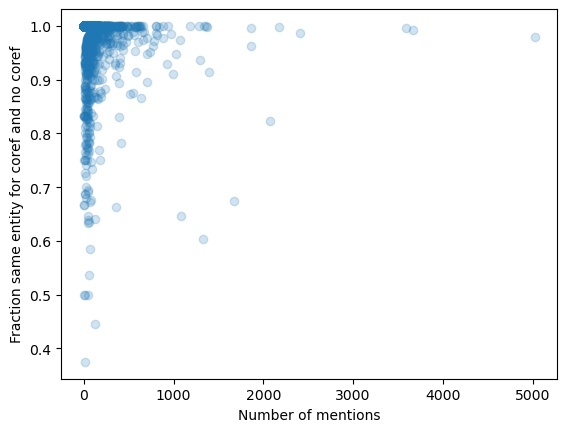

In [23]:

xlabel = 'Number of mentions'
ylabel = 'Fraction same entity for coref and no coref'

fig, ax = plt.subplots()

ax.scatter(x=d_agg['n_mentions'], y=d_agg['same_entity'], alpha=0.2)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)




Text(0, 0.5, 'Fraction same entity among for coreferenced mentions')

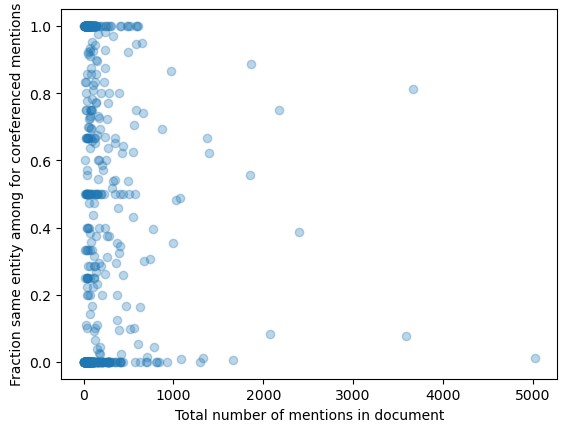

In [24]:
# repeat for only coreferring mentions

dtemp = d_compare.loc[d_compare['is_coref'] == 1,:]

d_agg = dtemp.groupby(dtemp['doc_id']).agg({"same_entity": "mean"})
d_size = d_compare.groupby(d_compare['doc_id']).size().to_frame('n_mentions')
d_n_corefs = dtemp.groupby(dtemp['doc_id']).size().to_frame('n_corefs')

d_agg = d_agg.join(d_size).join(d_n_corefs).reset_index()


xlabel = 'Total number of mentions in document'
ylabel = 'Fraction same entity among for coreferenced mentions'

fig, ax = plt.subplots()

ax.scatter(x=d_agg['n_mentions'], y=d_agg['same_entity'], alpha=0.3)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)


Notes
- no obvious change in fraction same entity with larger number of mentions 
- but in some documents it seems to make quite a difference
- but it also depends on whether there are many coreferences in a document.
    - So it would be good to count the number of corefs in a document and save them 
    - We expect performance to only change for coreferences!
    - Also, for very small number of mentions, one coreference can have a large impact 
    - So it would be important to do this only for the coreferring entities, in order not to have it being confounded by the vast majority of other mentions 
- is there a way to know/predict which entities are coreferred from a document, *without* running the search? 
    - train a model for predicting coreferences? 
- check predictions also for the aida data!
- what are the trade-offs here
    - the quadratic time effect only kicks in for quite large documents 
    - for smaller documents, I do not see any reason not to use with_coref 

In [28]:
dtemp.describe()

,field,start_pos,end_pos,ed_score_coref,is_coref,ed_score_nocoref,same_entity
count,8767.000000,8767.000000,8767.000000,8767.0,8767.0,8735.0,8767.000000
mean,1.996692,29739.288354,29745.304779,0.0,1.0,0.0,0.402760
std,0.059375,58870.778346,58870.410273,0.0,0.0,0.0,0.490481
min,0.000000,0.000000,4.000000,0.0,1.0,0.0,0.000000
25%,2.000000,3680.000000,3688.000000,0.0,1.0,0.0,0.000000
50%,2.000000,12475.000000,12480.000000,0.0,1.0,0.0,0.000000
75%,2.000000,31821.000000,31826.500000,0.0,1.0,0.0,1.000000
max,2.000000,734008.000000,734011.000000,0.0,1.0,0.0,1.000000


In [26]:
docid = "msmarco_doc_00_28953614"
ed_coref.loc[ed_coref.doc_id=="msmarco_doc_00_28953614"].shape
# ed_nocoref.loc[ed_coref.doc_id=="msmarco_doc_00_28953614"].shape


(3590, 8)

In [27]:
d_md = pd.read_parquet(f"../data/msmarco/msmarco_doc_md_00_5k.parquet")
d_md.loc[d_md["identifier"]==docid,:].shape

ed_nocoref.describe()


,field,start_pos,end_pos,ed_score_nocoref
count,256489.000000,256489.000000,256489.000000,256489.0
mean,1.947132,30447.001665,30455.373108,0.0
std,0.266198,81772.551942,81772.206601,0.0
min,0.000000,0.000000,2.000000,0.0
25%,2.000000,1881.000000,1890.000000,0.0
50%,2.000000,6986.000000,6994.000000,0.0
75%,2.000000,21666.000000,21671.000000,0.0
max,2.000000,745297.000000,745302.000000,0.0
